# <center>pytorch入门</center>

By [青衣极客 Blue Geek](https://mp.weixin.qq.com/s/rkzhDBAS3ARsOJ9ztNJJfw)

In 2019-10-16

最近在几个机器学习的顶级会议中，使用pytorch框架的论文占了大多数，pytorch也一跃成为最受科研工作者欢迎的机器学习框架。机器学习领域的朋友大概都是比较清楚的，在此之前，tensorflow是绝对的主流，但是现在形势发生了变化。很多科研工作者抛弃tensorflow的原因可以归纳为：1. 静态图的开发模式太局限；2. API不是面向用户的因此使用不方便；3. pytorch深度嵌入python掌握起来更容易。或许正式由于发现了tensorflow的这种劣势以及pytorch这种动态图的优势和吸引力，tensorflow的开发团队推出了2.0版本，全面拥抱动态图和面向用户的API。只是这次重大更新使得2.0版本与之前版本存在兼容性问题，那么用户在此关头就会有要不要继续使用tensorflow的考虑。毕竟目前开源框架中pytorch和tensorflow2.0是非常相似的。如果是工业生产，目前还是建议使用tensorflow，毕竟tf在生产环境中已经有很好的支持，而且更换生产环境的风险较大。如果是科研工作者，目前使用pytorch似乎是更有优势一点，毕竟顶级会议的优秀论文会提供pytorch版本的源码，学习方便。

其实说起来，两个框架都掌握一下似乎也并不是一件很困难的事情。用过pytorch和tensorflow2.0的朋友可能对此深有体会。只要对其中一个框架比较熟悉，那么看懂另一个框架的代码也问题不大。本文就是按照pytorch官网上的入门教程进行一次实验和学习。能够手动将这个实验做完，基本就掌握了pytorch搭建深度模型的一般方法，剩下的工作就是在实际开发中继续深入。

首先还是导入pytorch相关的一些模块。本文演示图像分类模型的搭建，使用的数据集为cifar10。pytorch提供了一些常用数据集读取相关的封装，比如torchvision就封装了计算机视觉中常用的数据集，cifar10就在其中。

In [69]:
import math
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
print(torch.__version__)

1.1.0.post2


## 1. 读取并展示部分样本

torchvision中提供的数据集封装需要使用迭代器进行读取，这样的好处是不需要一次将数据集读入内存，对于一些很大的数据集而言是必须使用的。此外，通常需要对图像数据进行一些预处理，比如图像归一化、图像增强、数据中心化以及图像截取和改变大小等等操作。在pytorch中，这些操作都可以放在数据载入的管道中进行。同时还可以设置多进程处理，以改善python全局解释锁对多核使用的限制。如果本地数据集不存在则需要下载，在国内往往下载速度极慢，一般建议复制下载链接，然后使用带有加速功能的下载器完成下载。

Files already downloaded and verified
Files already downloaded and verified
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([16, 3, 32, 32]) torch.Size([16])


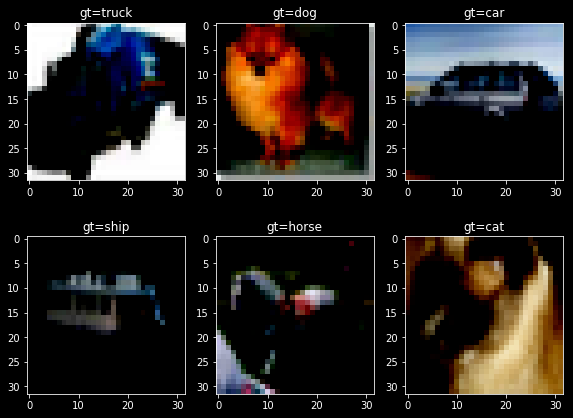

In [70]:
# 创建数据集读取管道
args = (0.5, 0.5, 0.5)
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=args, std=args)])
trainset = torchvision.datasets.CIFAR10(
    root='data/', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=16, shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(
    root='data/', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=16, shuffle=True, num_workers=2)
classes = ['plane', 'car', 'bird', 'cat','deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']
# 展示部分样本数据
data = iter(trainloader)
images, labels = data.next()
print(images.shape, labels.shape)
num_show = min(6, images.shape[0])
num_cols = 3
num_rows = math.ceil(num_show / 3)
plt.figure(figsize=(9.6, 7.2))
for idx in range(num_show):
    plt.subplot(num_rows, num_cols, idx+1)
    plt.imshow(np.transpose(images[idx, ...], (1,2,0)))
    plt.title('gt={}'.format(classes[labels[idx]]))


In [71]:
在获取一个batch的数据时，这里使用iter函数来创建迭代对象。这种操作使用在开头一般是没有什么问题的，但是如果使用在结尾处，往往会与其他方式的读取操作存在干扰，从而造成数据读取错位，而且不易发现。所以一般不建议这样读取。cifar10中的图像都是32x32的，分辨率较低。

SyntaxError: invalid character in identifier (<ipython-input-71-c944187b695b>, line 1)

## 2. 搭建网络

pytorch搭建网络结构的方式与keras比较类似，对开发者而言都是比较友好和直观的。pytorch的网络需要继承nn.Module类，然后在forward函数中搭建前向网络。需要注意的是，默认情况下，卷积的输出张量的形状跟tensorflow存在一点差异，即每次卷积之后，输出大小会减少卷积核大小的一半。当然，这种不一致可以通过配置参数进行修改。还有一个重要的不同在图像通道处于axis=1的维度上，而在tensorflow中，最后一个维度才是图像通道。pytorch的这种维度排列方式与caffe中的Blob是一致，但是却与一些其他第三方库不一致，比如在使用matplotlib可视化时，需要先将维度排列进行调整一下。

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool1(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)
        return x

## 3. 训练模型

pytorch训练模型的步骤可以说是更直观一些，而tensorflow则将若干个步骤合并到一起了。看过caffe源码的朋友可能很快就发现，这个过程与caffe中进行误差反传调整参数的过程是一致的。学习过梯度下降优化算法的朋友都知道，使用这种方法调整参数分三步：1. 前向计算损失，2.反向计算梯度，3.根据梯度更新参数。前向计算损失的过程是网络结构所规定的，反向计算梯度是链式求导法则所确定，而使用梯度作为启发信息更新参数则是优化器的工作。一般而言的参数调整，处理调整网络结构之外，就是调整优化器的参数，比如学习率lr、更新惯量momentum等等。为了监控是否发生了过拟合以及何时发生的，这里在若干次训练之后，使用测试集进行一次评估，观察训练损失和测试损失下载的趋势是否一致。

训练完成之后将模型参数保存到文件，以防止各种意外原因导致停机从而造成困扰。在实际使用时，应该在训练过程中设置一些保存点，以便在故障后快速恢复训练。

In [0]:
import torch.optim as optim 

net = Net()
loss = nn.CrossEntropyLoss()
opt = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)
loss_list = []
for epoch in range(50):
    sum_loss = .0
    for idx, dat in enumerate(trainloader, 0):
        imgs, lbls = dat # 获取一小批数据
        opt.zero_grad()  # 梯度归零
        out = net(imgs)  # 前向计算
        v_loss = loss(out, lbls)  # 计算损失值
        v_loss.backward()         # 根据损失计算梯度
        opt.step()                # 更新参数
        # 记录中间结果
        sum_loss += v_loss.item()
    loss_list.append(sum_loss/(idx+1))
    if epoch % 5 == 4:
        print('epoch[{}]-step[{}], loss={}'.format(
                    epoch+1, idx+1, loss_list[-1]))
        # 在测试集上评估损失，主要用于查看泛化能力，避免过拟合
        sum_loss = .0
        for idx, dat in enumerate(testloader, 0):
            imgs, lbls = dat
            out = net(imgs)
            v_loss = loss(out, lbls)
            sum_loss += v_loss.item()
        print('evaluate on testset, loss={}'.format(sum_loss / (idx+1)))
# 保存模型到文件
torch.save(net.state_dict(), 'output/cifar10.pth')
print('train model completely')
# 绘制训练过程损失变化曲线图
plt.plot(np.arange(len(loss_list)), np.array(loss_list), '-o')

从训练曲线来看，训练过程并没有完全收敛，增加训练次数会进一步提高精度。不过这里考虑到时间因素，就到这里结束训练了。

## 4. 使用模型预测

模型训练完毕之后就需要将模型投入到实际使用中进行预测。这里在cifar10的测试集中选择一个batch的样本进行预测测试。在预测之前，需要先创建网络结构对象，然后从文件中载入模型参数。

In [0]:
# 载入模型
net_app = Net()
net_app.load_state_dict(torch.load('output/cifar10.pth'))
# 获取一个batch的数据
for idx, dat in enumerate(testloader, 0):
    images, labels = dat
    break
# 预测
preds = net_app(images)
preds = np.argmax(preds.data.numpy(), axis=1)
# 绘制预测结果和均值
num_show = min(6, images.shape[0])
num_cols = 3
num_rows = math.ceil(num_show / 3)
plt.figure(figsize=(9.6, 7.2))
for idx in range(num_show):
    plt.subplot(num_rows, num_cols, idx+1)
    plt.imshow(np.transpose(images[idx, ...], (1,2,0)))
    gt_cate = classes[labels[idx]]
    pred_cate = classes[preds[idx]]
    plt.title('gt={} & pred={}'.format(gt_cate, pred_cate))


从预测的结果来看，应该说大部分都能预测正确，但是正确率并不高，也就是说模型还有进一步提升的空间。

到此，pytorch入门的实验就讨论完毕，对pytorch感兴趣或者决定拥抱pytorch的朋友可以由此进入pytorch的世界。